# EX1. Retrieval Augmented Generation and Search

Welcome to the **Retrieval Augmented Generation (RAG) and Search** example for the BRAD Python package! This tutorial is designed to introduce tool modules of BRAD that couple LLMs with traditional research modalities. In this tutorial, you will learn to:
1. Use BRAD with RAG to search and summarize research articles.
2. Query bioinformatics databases with BRAD.
3. Search literature repositories using BRAD.
4. Create and integrate new tools into BRAD using a standard template.

We will explore different inputs, configurations, and keywords that enable BRAD to perform these tasks effectively. Let's get started by importing the BRAD package!

---


In [1]:
from BRAD import agent

2024-11-21 18:58:00.133572: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-21 18:58:00.151588: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-21 18:58:00.157105: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 18:58:00.171435: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-21 18:58:01.663000: W tensorflow/comp

## Retrieval Augmented Generation (RAG)

RAG combines the strengths of LLMs and information retrieval. It works by first searching external data sources, like documents or databases, to find relevant information. This information is then provided to the LLM, which uses it to generate accurate and contextually relevant responses. By grounding its answers in real data, RAG helps avoid mistakes and ensures the output is more reliable and informed. This makes it especially useful for tasks like answering questions, summarizing information, and exploring specific topics.

During run time, RAG has three phases:
1. document retrieval, which uses search methods like similarity search
2. text augmentation, such as summarization or enrichment
3. LLM generation, which is performed using prompting.

Prior to run time, the RAG database must be constructed. To build a document database, we will use the `PDF` files found in `papers/` and the `BRAD.rag` module, which we import next. Each tool module of BRAD resides in its own python module, in this case named `rag` and imported as:


In [3]:
from BRAD import rag

### Create a Database

Constructing the database involves organizing a collection of documents into a format optimized for retrieval. First, documents are split into smaller, manageable chunks of text, typically a few sentences or paragraphs. These chunks are then converted into numerical representations called vectors using an embedding model, which maps the text into a high-dimensional vector space. The resulting paired vectors and text chunks are stored in a database, so that vector similarity measures can be used to find relevant text.

**Note to reader:** We build a database with one paper about cellular reprogramming that is found within `papers/`, but we encourage you to replace our paper with a document of interest to you!

In BRAD, the database construction is implemented with the following method:

In [4]:
rag_database = rag.create_database(
    docsPath='papers/',          # location of papers to put in database
    dbName='tutorialDatabase',   # name of the database
    dbPath='databases/',         # location where to place the database
    v=True                       # verbose output
)


Work Directory: /home/jpic/BRAD-Examples/RAG-SCRAPE


/home/jpic/.local/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Documents loading from: 'str(docsPath)


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]



Documents loaded...
Documents split into chunks...
Initializing Chroma Database...
dbName reset


---

When complete, the following directory structure will appear:

```
├── config-ex-1.json
├── databases
│   └── tutorialDatabase
│       ├── 598f3f85-63bf-4fb6-995f-104ca1673566
│       │   ├── data_level0.bin
│       │   ├── header.bin
│       │   ├── length.bin
│       │   └── link_lists.bin
│       └── chroma.sqlite3
├── Example-1.ipynb

```




Here, `databases/` is a directory that contains the `tutorialDatabase/` directory. The structure of the `tutorialDatabase/` directory is important and is the location where the text chunks and vector representations will be saved on the file system.

Database construction can be relatively slow and depends on the number of documents you have. However, this is a one time fixed cost and in subsequent uses of the database, it can be loaded back into memory directly from the file system.

### Configure the `Agent`

Once the RAG database is constructed, we can use it to chat with our documents. To do this, the RAG database is passed as a parameter when constructing an `Agent`:

In [16]:
bot = agent.Agent(
    ragvectordb=rag_database, # Give the RAG database to the agent
    config='config-ex-1.json' # Give the configurations to the agent
)

2024-11-21 18:51:16 INFO semantic_router.utils.logger local


Welcome to BRAD! The output from this conversation will be saved to /home/jpic/BRAD-Examples/RAG-SCRAPE/output/November 21, 2024 at 06:51:15 PM/log.json. How can I help?


---

In addition to the RAG database, we also specify a configuration file for this `Agent`. This file overrides the default configurations built into the BRAD package. The RAG module of BRAD has the following configurations:

```
"RAG": {
    "num_articles_retrieved": 3,     # number of articles during retrieval
    "similarity": false,             # retrieve the most similar articles
    "mmr": true                      # retrieve based on maximal marginal relevance
    "multiquery": false,             # retrieve using LLM augmented queries
    "contextual_compression": false, # summarize documents after retrieval prior to generation
    "documentEnrichment": false,     # search for surrounding text of the retrieved documents
},
```

The `similarity`, [`mmr`](https://python.langchain.com/v0.1/docs/modules/model_io/prompts/example_selectors/mmr/), and [`multiquery`](https://python.langchain.com/docs/how_to/MultiQueryRetriever/) parameters retrieve `num_articles_retrieved` documents from the database. One of these three arguments should be `true`. `contextual_compression` and `documentEnrichment` are two established methods of document augmentation prior to the generation phase. These can be either `true` or `false`.

An important configuration of BRAD (not particular to RAG) is the `debug` value (`0` or `1`). Using `debug` mode will display additional information below to illustrate how the RAG process works. In particular, the <span style="color:green;">**green**</span> text below is the prompt that is input to the LLM. This system prompt contains three pieces:
1. system instructions: answer the question based on the pieces of information
2. three paragraphs of information taken from the paper in your database
3. the users question (bottom) is the last part of the prompt

The final output produced by the RAG pipeline appears at the bottom after "**Finished chain.
** If this is run without `debug` mode, only the final output will be displayed to the user."

### Query the RAG

To query the RAG pipeline, we use the `invoke` or `chat` methods, similar to the Hello World example:

In [17]:
response = bot.invoke("What is a topologically associated domain?")

2024-11-21 18:51:26,466 - INFO - RAG


BRAD >> 1: 


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
System: Use the following pieces of context to answer the user's question. 
If you don't know the answer, just say that you don't know, don't try to make up an answer.
----------------
Source: Algorithm for cellular reprogramming.pdf
Content: BIOPHYSICS AND
COMPUTATIONAL BIOLOGYSYSTEMS BIOLOGYstate. In addition, we demonstrate the efﬁcacy of using topologi-
cally associating domains (TADs) for genome dimension reduc-
tion. Implicit in this approach is the notion of distance between
cell types, which is measured in terms of the amount of transcrip-
tional change required to transform one cell type into another.
In this way, we are able to provide a comprehensive quantita-
tive view of human cell types based on the respective distances
between them.
Our framework separates into three parts:
i)Deﬁne the state. Use structure and function observations of
the initial and targ

2024-11-21 18:51:27,665 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-21 18:51:27,668 - INFO - 


route



2024-11-21 18:51:27,669 - INFO - RAG



> Finished chain.

> Finished chain.
A topologically associated domain (TAD) is a structural unit of chromosomes, which are contiguous segments of the 1D genome where empirical physical interactions can be observed. Genes within a TAD tend to exhibit similar activity, and TAD boundaries are largely cell-type invariant. TADs group structurally and functionally similar genes, serving as a natural dimension reduction that preserves important genomic properties.
Sources:
Algorithm for cellular reprogramming.pdf


## Search Enrichr

Traditional RAG relies on literature to enhance the capabilities of LLMs, but other rich sources of information, such as bioinformatics databases, can also be leveraged for augmentation. To this end, we implemented retrieval mechanisms that extract information from bioinformatics resources, including databases like [Enrichr](https://maayanlab.cloud/Enrichr/).

While LLM only and document RAG features are always accessible to BRAD, the user can specificy which additional `tool` modules an `Agent` has access to, using the `tools` argument below. The `DATABASE` tool lets the user search Enrichr.

In [8]:
bot = agent.Agent(
    tools = ['DATABASE'],     # Specify which tool modules can be used
    config='config-ex-1-nodebug.json' # Give the configurations to the agent
)


Would you like to use a database with BRAD [Y/N]?


 N


2024-11-21 19:08:56 INFO semantic_router.utils.logger local


Welcome to BRAD! The output from this conversation will be saved to /home/jpic/BRAD-Examples/RAG-SCRAPE/output/November 21, 2024 at 07:08:54 PM/log.json. How can I help?


---

In addition to specifying the avilable tools, users can use the **/force DATABASE** keyword to ensure that `BRAD` processes the query with the database search tool. In general, when **/force** is not used, a [semantic routering layer](https://github.com/aurelio-labs/semantic-router) acts to determine which tool best responds to an individual user query. The semantic router is initialized based on example user inputs associated with each tool. These can be found within [`BRAD/routers`](https://github.com/Jpickard1/BRAD/tree/main/BRAD/routers). Over time, when `state['config']['ROUTER']['build router db']` is set as `True` from the configuration files, the example prompts will be updated based on how the user uses the **/force** keyword to direct prompts to different tools. For example, when a user gives the input `/force TOOL <prompt>`, the `<prompt>` text will be added to the example prompts found withing `TOOL.txt` [here](https://github.com/Jpickard1/BRAD/tree/main/BRAD/routers).

For this particular tool, BRAD will construct a query to the Enrichr API based upon the human users question. Then, the database will return information, in the form of a table and image. The retrieved text information returned by the database are passed to the LLM to respond to the user.

BRAD >> 1: 


2024-11-21 19:09:02,787 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
19:09:02 - INFO - Performing Enichr analysis using database GO_Biological_Process_2021.
2024-11-21 19:09:02,802 - INFO - Performing Enichr analysis using database GO_Biological_Process_2021.


The following table was generated by quering the gene list against GO_Biological_Process_2021:

---

|    | path_name                                                                        |      p_val | overlapping_genes   |
|---:|:---------------------------------------------------------------------------------|-----------:|:--------------------|
|  0 | response to denervation involved in regulation of muscle adaptation (GO:0014894) | 0.00124947 | ['MYOG']            |
|  1 | endodermal cell fate specification (GO:0001714)                                  | 0.00124947 | ['SOX2']            |
|  2 | positive regulation of skeletal muscle fiber development (GO:0048743)            | 0.00149922 | ['MYOG']            |
|  3 | pituitary gland development (GO:0021983)                                         | 0.00174892 | ['SOX2']            |
|  4 | regulation of skeletal muscle satellite cell proliferation (GO:0014842)          | 0.00174892 | ['MYOG']            |
|  5 | positive regulati

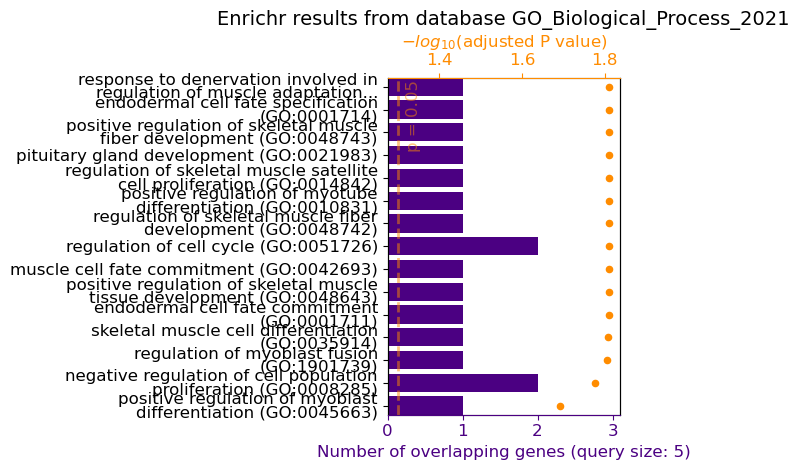

2024-11-21 19:09:06,492 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


response='Based on the search results from the ENRICHR database for the genes MYOD, MYOG, c-MYC, OCT4 (POU5F1), and SOX2, we found several significant biological processes associated with these genes. \n\n1. Response to denervation involved in regulation of muscle adaptation is associated with MYOG.\n2. Endodermal cell fate specification is associated with SOX2.\n3. Positive regulation of skeletal muscle fiber development is associated with MYOG.\n4. Pituitary gland development is associated with SOX2.\n5. Regulation of skeletal muscle satellite cell proliferation is associated with MYOG.\n6. Positive regulation of myotube differentiation is associated with MYOG.\n7. Regulation of skeletal muscle fiber development is associated with MYOG.\n8. Regulation of cell cycle is associated with MYOG and SOX2.\n9. Muscle cell fate commitment is associated with MYOG.\n10. Positive regulation of skeletal muscle tissue development is associated with MYOG.\n\nThese results provide insights into the 

In [9]:
response = bot.invoke('/force DATABASE search enrichr for the genes: MYOD, MYOG, CMYC, OCT4 (POU5F1), SOX2')

## Searching Arxiv

Similar to the `DATABASE` tool, the `SCRAPE` tool allows users to search literature repositories to find recent publications and information. These articles can the be downloaded, and incorporated into a RAG database.

In [10]:
bot = agent.Agent(
    config='config-ex-1-nodebug.json'
).chat()


Would you like to use a database with BRAD [Y/N]?


 N


2024-11-21 19:10:35 INFO semantic_router.utils.logger local


Welcome to BRAD! The output from this conversation will be saved to /home/jpic/BRAD-Examples/RAG-SCRAPE/output/November 21, 2024 at 07:10:32 PM/log.json. How can I help?


Input >>  /force SCRAPE search arxiv for literature on cellular reprograming


BRAD >> 1: 


2024-11-21 19:11:02,956 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


searching the following on arxiv: cellular reprogramming


,Title,Authors
0,Cellreprogrammingdesign by transfer learning o...,"Thomas P. Wytock,Adilson E. Motter"
1,Deep Reinforcement Learning for Controlled Tra...,"Andrzej Mizera,Jakub Zarzycki"
2,Towards Early Prediction of Human iPSCReprogra...,"Abhineet Singh,Ila Jasra,Omar Mouhammed,Nidhee..."
3,The Growing Liberality Observed in Primary Ani...,Norichika Ogata
4,Marker and source-markerreprogrammingof Most P...,Loïc Paulevé
5,Reconstructing data-driven governing equations...,Jianhua Xing
6,Dynamical-systems theory ofcellularreprogramming,"Yuuki Matsushita,Tetsuhiro S. Hatakeyama,Kunih..."
7,The basal level of gene expression associated ...,"Gilles Flouriot,Charly Jehanno,Yann Le Page,Pa..."
8,Using single-cell entropy to describe the dyna...,"Yusong Ye,Zhuoqin Yang,Jinzhi Lei"
9,A model of dynamic stability of H3K9me3 hetero...,"Charly Jehanno,Gilles Flouriot,Pascale Le Goff..."



 Would you like to download these articles [Y/N]?


Input >>  Y


BRAD >> 2: 
The following articles were downloaded:

https://arxiv.org/pdf/2403.04837
https://arxiv.org/pdf/2402.08491
https://arxiv.org/pdf/2305.14575
https://arxiv.org/pdf/2301.02433
https://arxiv.org/pdf/2207.13307
https://arxiv.org/pdf/2203.14964
https://arxiv.org/pdf/2109.04739
https://arxiv.org/pdf/2012.12962
https://arxiv.org/pdf/2004.07985
https://arxiv.org/pdf/1801.05766



Input >>  exit


Thanks for chatting today! I hope to talk soon, and don't forget that a record of this conversation is available at: /home/jpic/BRAD-Examples/RAG-SCRAPE/output/November 21, 2024 at 07:10:32 PM/log.json


## Creating New Tool Modules

The `RAG`, `DATABASE`, and `SEARCH` modules are reliably implemented and integrated into both the BRAD GUI and the Python package. The `Agent` class is designed for easy extension, enabling the addition of new tool modules with minimal effort.

To create a new tool module, the following changes must be made in the code:

1. **Create a New Python File**  
   Add a new Python file in the `BRAD/` directory. This file must include:
   - A **tool method** that accepts and returns a Python dictionary, representing the `Agent.state`.
   - Any necessary **helper methods** to support the tool.

2. **Update the Semantic Router**  
   - Add a new set of routing files in the `BRAD/routes/` directory, allowing the semantic router to recognize when to select the tool.
   - Update the `BRAD.routers.getRoutes()` method to include example prompts that guide the semantic router in using the new tool.

3. **Modify the `Agent` Class**  
   - Add the necessary imports in `agent.py` to include the new tool.
   - Update the `Agent.getModules()` method to register the tool's main method.

Following these steps ensures that the new tool is fully integrated into BRAD’s architecture and ready for use.
  
We will show how we prototyped a `SOFTWARE` tool module aimed at execution bioinformatics scripts in the subsequent [examples](https://github.com/Jpickard1/BRAD-Examples/tree/main/Scanpy).